In [3]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [1]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple, Iterable, Any

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map
import seaborn as sns

import config

In [2]:
import torch
from torch.distributions import kl_divergence
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.dirichlet import Dirichlet
from ParameterizedModel.parameterized_model import Paremeterized_Model
from ParameterizedModel.utils.distribution_helpers import mean_std_to_beta_params

from ParameterizedModel.training import Trainer

In [3]:
from gradient_solver import construct_distance_matrix

In [4]:
import timeit

In [5]:
from IPython.display import display, Math, Latex

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
from scipy.spatial.distance import correlation

In [8]:
from gradient_solver import *

In [9]:
mode = 0

In [10]:
if mode == 0:
    df_explainable = pd.read_csv('../tst/df_explainable.csv',index_col=0)
    df_observable = pd.read_csv('../tst/df_observable.csv', index_col=0)
    index_name = 'Messung'
    observed_features = ['Durchfall', 'Verstopfung', 'Bauchschmerzen', 'Aufgebläht', 'Sodbrennen', 'Erschöpfung']

    df_explainable.Verweildauer_Minimum = df_explainable.Verweildauer_Minimum.apply(lambda x: pd.Timedelta(x).total_seconds())
    df_explainable.Verweildauer_Maximum = df_explainable.Verweildauer_Maximum.apply(lambda x: pd.Timedelta(x).total_seconds())
    df_explainable = df_explainable.drop(columns = ['Expiration_Minimum','Expiration_Maximum','Datum'])

    explaining_features = []
    for column in df_explainable.columns:
        if column == index_name or column == 'Datum':
            continue
        if df_explainable.loc[:, column].max() > 0:
            explaining_features.append(column)

In [11]:
if mode == 1:

    df_observable = pd.read_excel('../data/biological_set_raw_data.xlsx')
    df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features()
    df_observable_distances: pd.DataFrame = pd.read_excel(
        f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
        index_col=0
    )
    features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

    # Ensure that both datasets contain the same indices
    valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)
    df_explainable = df_explainable.loc[valid_indices]
    df_observable_distances = df_observable_distances.loc[valid_indices]

    index_name = config.GROUP_NAME
    observed_features = list(config.OBSERVABLE_FEATURE_NAMES.keys())
    explaining_features = list(config.EXPLAINING_FEATURE_NAMES.keys())

In [12]:
##################
# Synthetic Data #
##################
if mode == 2:
    individuals = 5
    base_size = 10

    #observation_data = np.random.normal(loc=0, scale=1, size=(base_size, 6))
    '''explanation_data = np.random.uniform(0,1, size=(individuals, 11))
    df_explainable = pd.DataFrame(explanation_data)
    df_explainable.loc[:, 'Individual'] = [f'Individual_{i}' for i in df_explainable.index]
    df_explainable.set_index('Individual', inplace=True)'''

    df_explainable = pd.DataFrame({
        'Age': np.random.choice([0., 0.5, 1.], individuals),
        'Weight': np.random.uniform(0,1, size=individuals),
        'Is_a_Zebra': np.random.choice([0., 1.], individuals),
        'Loves_to_sleep': np.random.uniform(0,1, size=individuals),
        'Noise_1': np.random.uniform(0,1, size=individuals),
        'Noise_2': np.random.uniform(0,1, size=individuals),
        'Noise_3': np.random.uniform(0,1, size=individuals),
        'Noise_4': np.random.uniform(0,1, size=individuals),
        'Noise_5': np.random.uniform(0,1, size=individuals),
        'Individual': [f'Individual_{n}' for n in range(individuals)]
    })
    df_explainable.set_index('Individual', inplace=True)

    explaining_features = np.array(list(df_explainable.columns))
    individual_array = np.random.choice(df_explainable.index.unique(), size=base_size)

    df_observable = pd.DataFrame({
        'Individual': individual_array,
    })
    df_observable.loc[:, 'unexplainable_1'] = np.random.uniform(0,1, size=base_size)
    df_observable.loc[:, 'unexplainable_2'] = np.random.uniform(0,1, size=base_size)
    df_observable.loc[:, 'unexplainable_3'] = np.random.uniform(0,1, size=base_size)
    df_observable.loc[:, 'unexplainable_4'] = np.random.normal(0,1, size=base_size)

    df_observable.loc[:, 'if_zebra_then_age'] = (df_explainable.loc[individual_array, 'Is_a_Zebra'].values > 0.65) * df_explainable.loc[individual_array, 'Age'].values + (df_explainable.loc[individual_array, 'Is_a_Zebra'].values <= 0.65) * np.random.uniform(0,1, size=base_size)
    df_observable.loc[:, 'explained_by_loves_to_sleep'] = df_explainable.loc[individual_array, 'Loves_to_sleep'].values #df_explainable.loc[individual_array, [1,2,3]].mean(axis=1).values #req_1 * df_explainable.loc[individual_array, 2].values + (1-req_1) * df_explainable.loc[individual_array, 3].values
    df_observable.loc[:, 'Age_plus_Weight'] = df_explainable.loc[individual_array, 'Age'].values + df_explainable.loc[individual_array, 'Weight'].values

    df_observable.set_index('Individual', inplace=True)
    observed_features = list(df_observable.columns)

    df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [13]:
##################
# Synthetic Data #
##################

if mode == 3:

    def uniform_list(von, bis, num):
        lis = list(Uniform(von, bis).sample([num]))
        return [float(li) for li in lis]

    N = 100
    z_N = 10
    z_age = [float(li) for li in (uniform_list(0.9/(z_N-1), 0.999/(z_N-1), z_N) * np.arange(z_N))]
    _z_age = uniform_list(0.0001, 0.9999, N-z_N)
    dummy_explainables = pd.DataFrame({
        'Age': z_age + _z_age,
        'Is_a_Zebra': uniform_list(0.9967, 0.9999, z_N) + uniform_list(0.0005, 0.0013, N-z_N),
        'Noise_0': Uniform(0,1).sample([N]),
        'Noise_1': Uniform(0,1).sample([N]),
        'Individual': [f'Individual_{i}' for i in range(N)]
    })

    dummy_explainables.set_index('Individual', inplace=True)

    K = 20
    lis = []
    for k in range(K):
        lis = lis + [z+u for z,u in zip(z_age, uniform_list(0.0001, 0.0150, z_N))] + uniform_list(0.0001, 0.9999, N-z_N)

    dummy_observables = pd.DataFrame({
        'Individual': [f'Individual_{n}' for n in range(N)] * K,
        'if_zebra_then_age': lis,
        'unexplainable_1': Uniform(0,1).sample([N*K]),
        'unexplainable_2': Uniform(0,1).sample([N*K]),
    })

    showcase_df = dummy_observables.copy()
    for individual in showcase_df.Individual.unique():
        idx = showcase_df.query(f'Individual == "{individual}"').index
        showcase_df.loc[idx, 'Age'] = dummy_explainables.loc[individual].Age
        showcase_df.loc[idx, 'Zebra'] = dummy_explainables.loc[individual].Is_a_Zebra
        showcase_df.loc[idx, 'bool_Zebra'] = dummy_explainables.loc[individual].Is_a_Zebra > 0.5

    index_name = 'Individual'

    df_observable = dummy_observables
    df_explainable = dummy_explainables

    observed_features = []
    for f in df_observable:
        if f != index_name:
            observed_features.append(f)

    explaining_features = []
    for f in df_explainable:
        if f != index_name:
            explaining_features.append(f)       

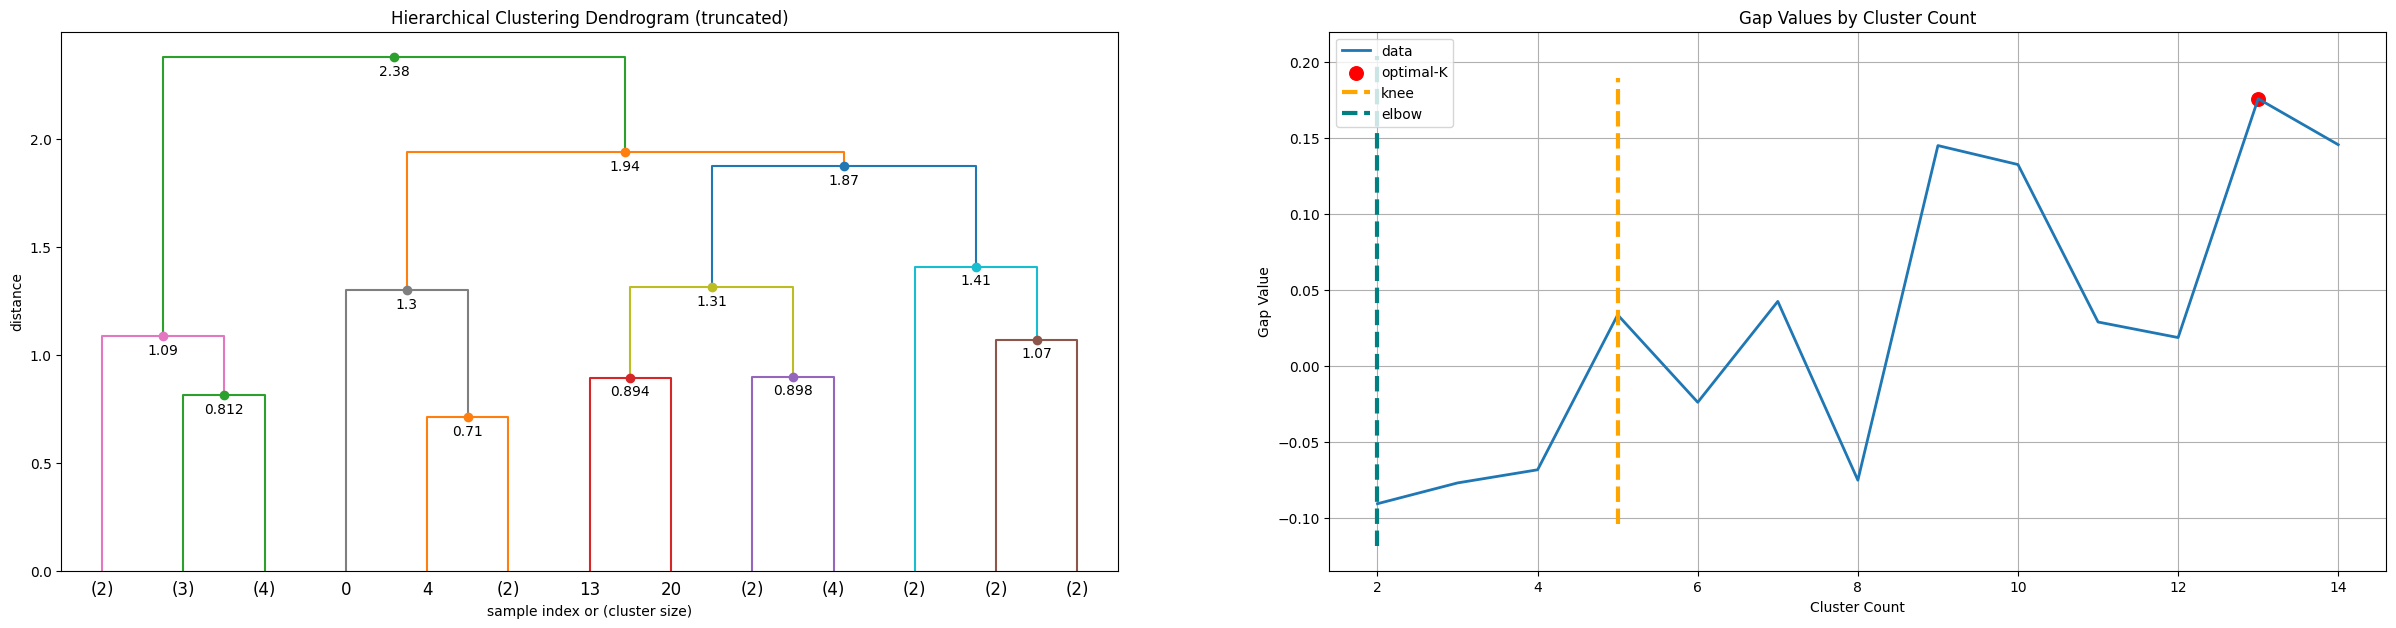

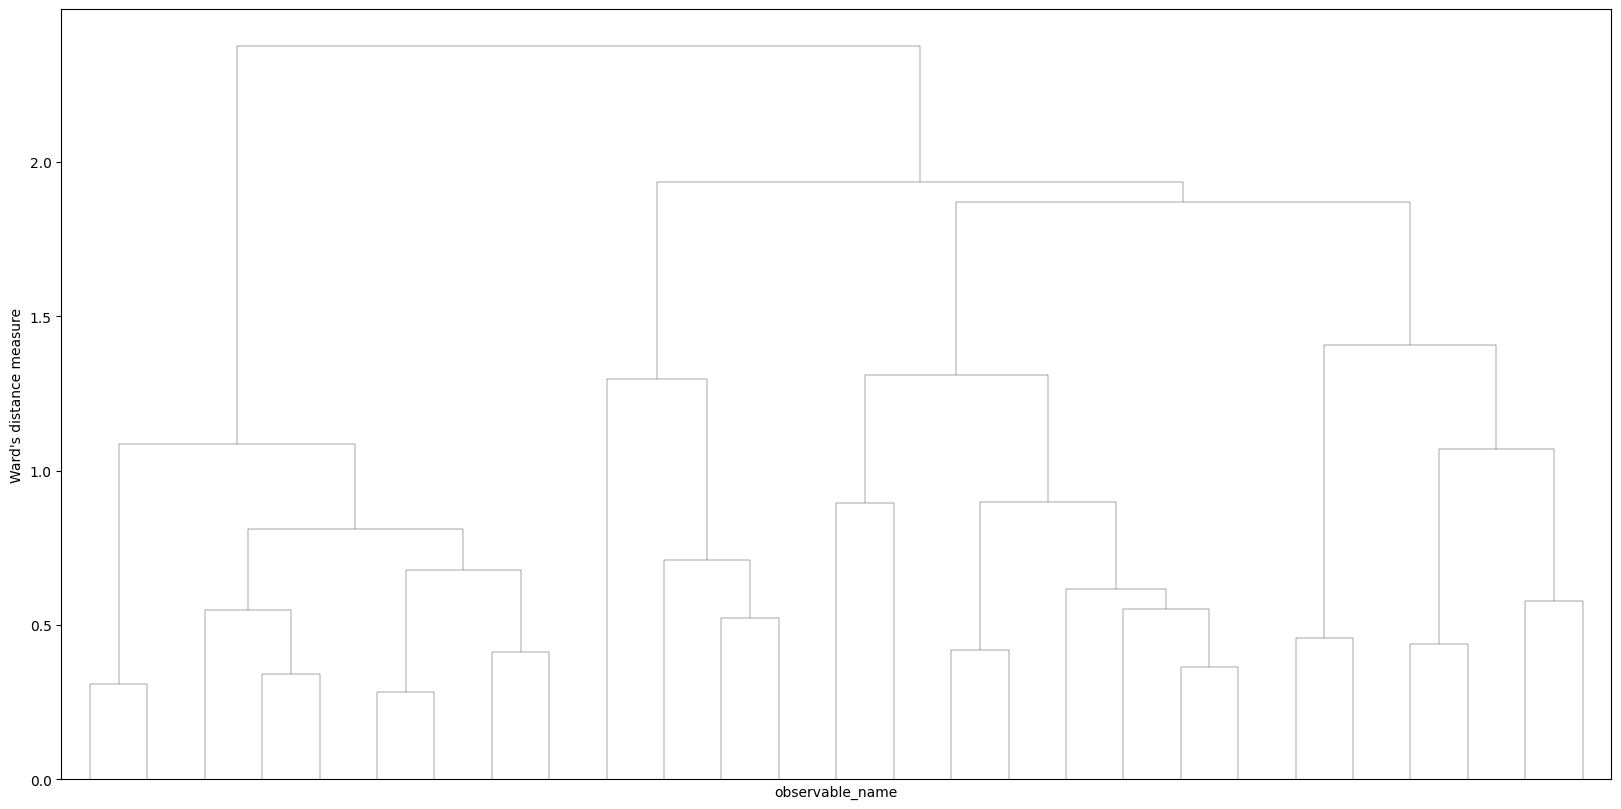

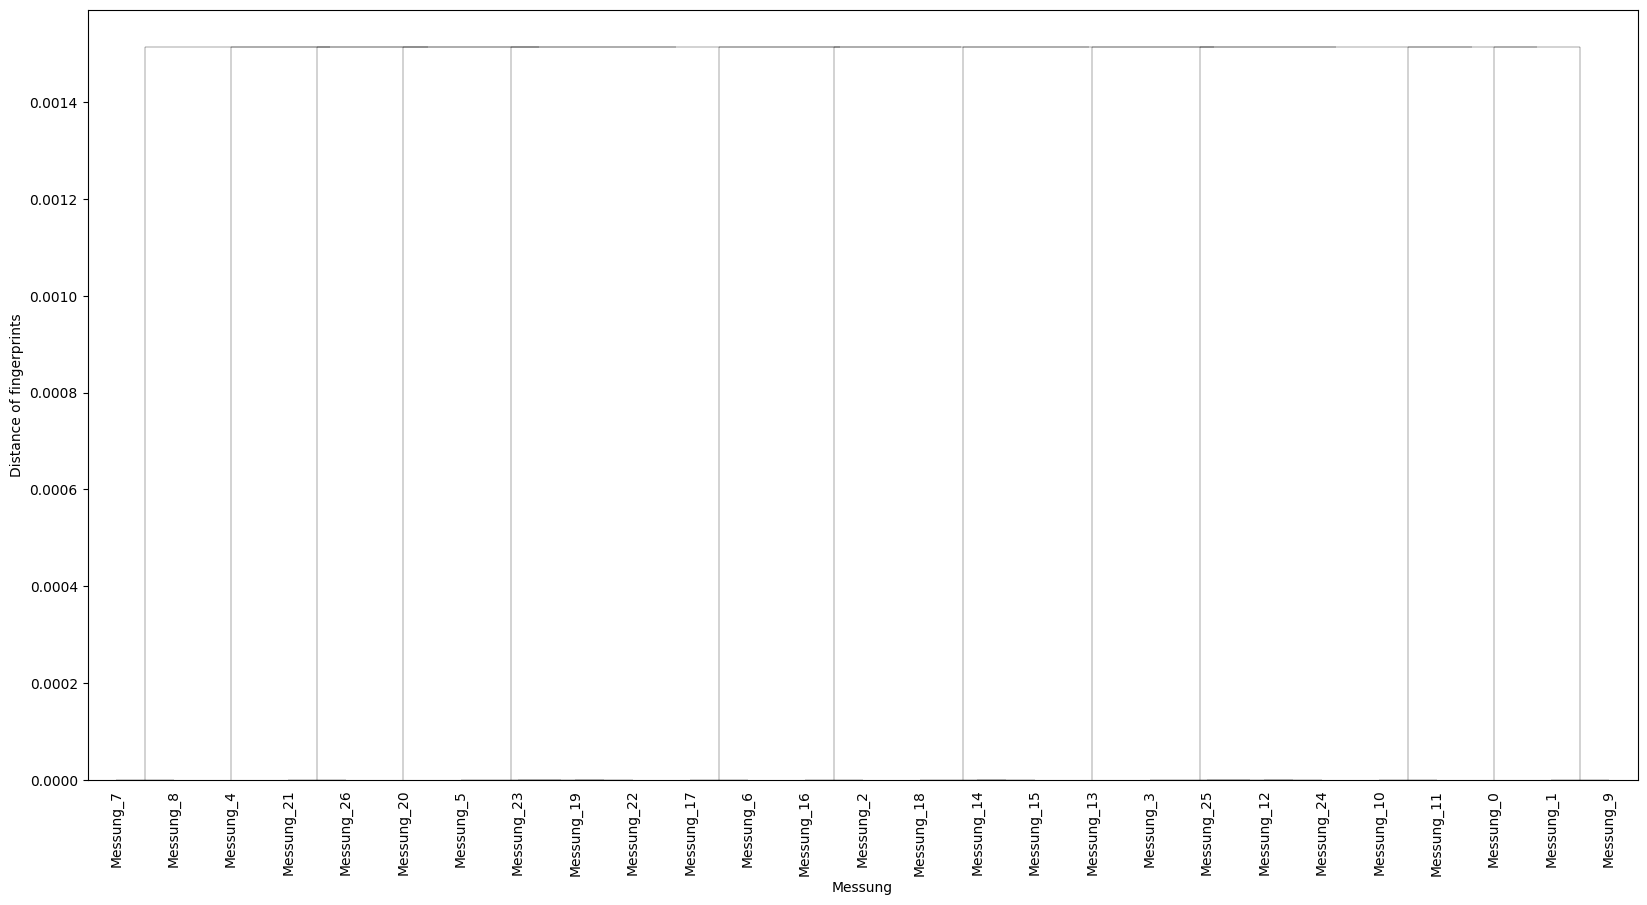

In [14]:
#index_name = 'Individual'
my_linkage = 'ward' #'single'

from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable.reset_index(),
    df_explainable=df_explainable.reset_index(),
    distortion_mean=0.01,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name,
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15,
    linkage='ward'
)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters= optimal_number_of_clusters['n_clusters'],
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
    #spiderplot_scaling='minmax',
    linkage=my_linkage
)

In [15]:
observable_patterns_result['spider_plots']

  0%|          | 0/1023 [00:00<?, ?it/s]

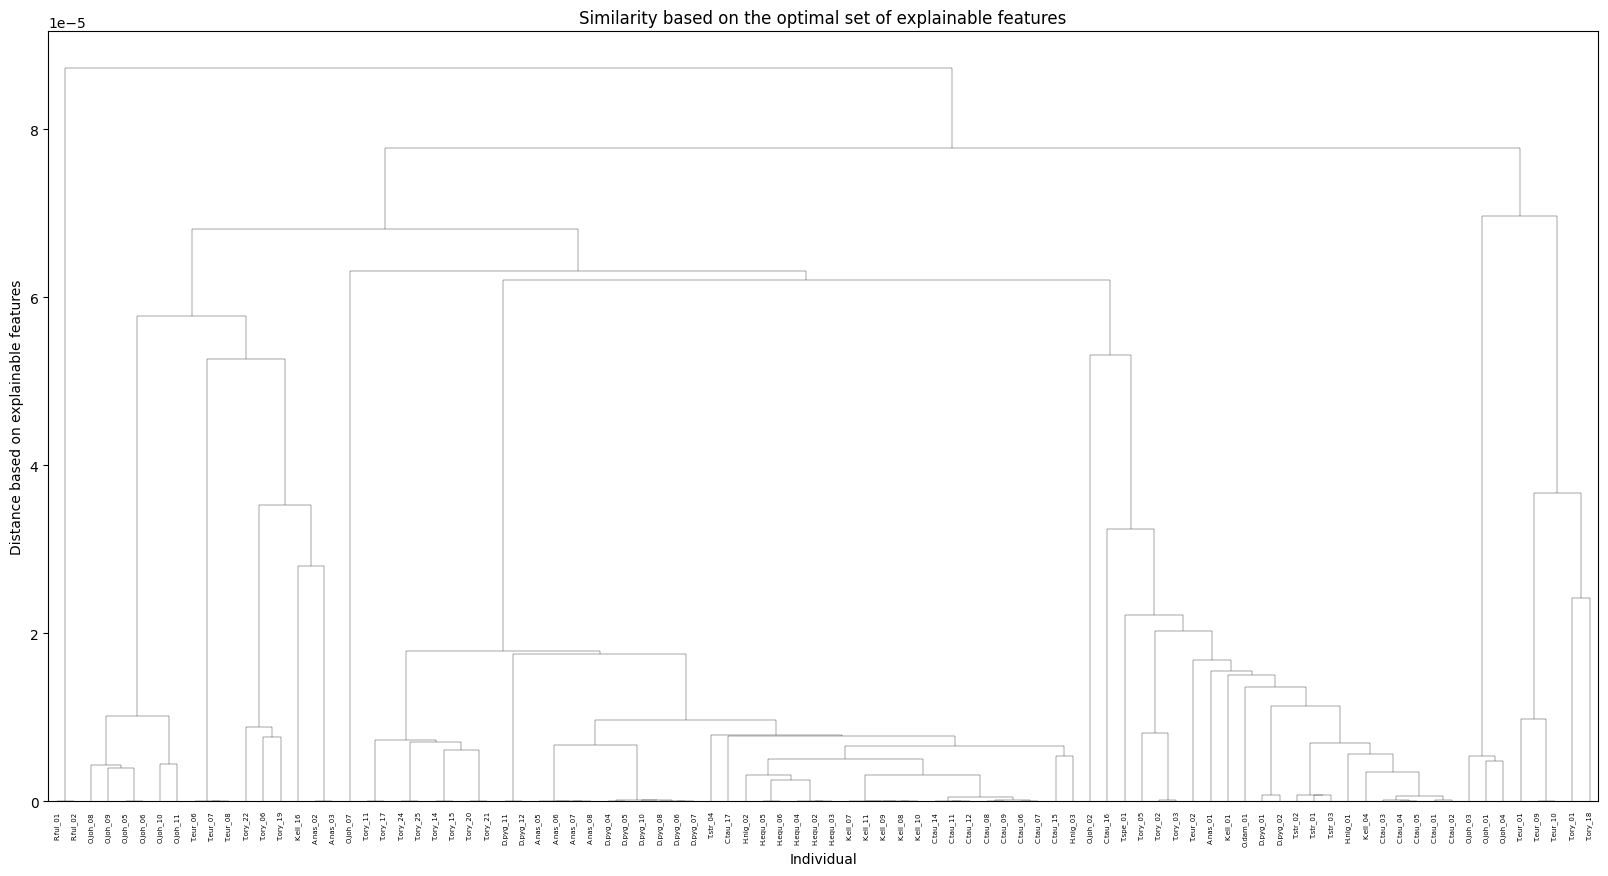

In [17]:
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),#.loc[:, q].apply(lambda x: np.nan_to_num(x)).set_index(index_name).loc[valid_indices],
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),#.loc[valid_indices, :].loc[:, valid_indices],
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [45]:
calculate_explainable_distances_result['overview_df']

NameError: name 'calculate_explainable_distances_result' is not defined

In [16]:
def ward_distance(x, y):
    # Compute the centroids of the two clusters
    centroid_x = torch.mean(x, dim=0)
    centroid_y = torch.mean(y, dim=0)

    # Compute the variance within each cluster
    var_x = torch.sum((x - centroid_x) ** 2) / (x.shape[0] - 1)
    var_y = torch.sum((y - centroid_y) ** 2) / (y.shape[0] - 1)

    # Compute the variance between the two clusters
    var_between = torch.sum((centroid_x - centroid_y) ** 2)

    # Compute the Ward distance
    return var_between + var_x + var_y

In [17]:
keystr = 'df_observable_data'

x = torch.tensor(observable_patterns_result[keystr].loc[:, observed_features].to_numpy())
y = torch.tensor(observable_patterns_result['df_cluster_median'].to_numpy())

alternative = ((x.unsqueeze(1) - y.unsqueeze(0)).pow(2).clamp(min=1e-20)).sum(2).sqrt()

vergleich = observable_patterns_result['df_observable_data'].pattern_type == alternative.argmin(dim=1).numpy() #torch.cdist(x, y).argmin(dim=1).numpy()
print(vergleich)
print(vergleich.sum() / observable_patterns_result[keystr].shape[0])

print(alternative.argmin(dim=1).numpy()[:23])
print(observable_patterns_result['df_observable_data'].pattern_type[:23].to_numpy())

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
Name: pattern_type, dtype: bool
0.9629629629629629
[ 6  5  4  2 12  0  1  3  3  5  9  9  2 10 11 11  4  1  0  0  8  7  0]
[ 6  5  4  2 12  0  1  3  3  5  9  9  2 10 11 11  4  1 11  0  8  7  0]


In [18]:
my_df = observable_patterns_result[keystr].copy()
my_df = my_df[my_df["oversampled"] == False]

In [19]:
my_df.loc[:, [index_name] + observed_features]

,Messung,Durchfall,Verstopfung,Bauchschmerzen,Aufgebläht,Sodbrennen,Erschöpfung
0,Messung_0,1.011321,0.758429,0.843074,0.675532,1.012130,0.633158
1,Messung_1,0.009678,0.883422,0.677972,0.676991,0.810343,0.634473
2,Messung_2,0.009758,0.260900,0.344141,0.341503,0.410020,0.885520
3,Messung_3,0.009589,0.509201,0.343151,0.342053,0.808980,0.384565
4,Messung_4,0.581795,0.760529,0.677499,0.453035,0.208472,0.261482
5,Messung_5,0.726038,0.010631,0.676487,0.232441,0.009961,0.010309
6,Messung_6,0.439555,0.510668,1.009428,0.010544,0.410460,0.008982
7,Messung_7,0.008595,0.383205,0.843816,1.010590,0.209376,0.260549
8,Messung_8,0.009259,0.260294,0.509790,0.785919,0.209956,0.134512
9,Messung_9,0.010329,0.383823,0.508453,0.788937,0.607477,0.635500


In [20]:
df_observable_distances = observable_patterns_result['pw_norm_dist']
df_observable_distances.head()

Messung,Messung_0,Messung_1,Messung_10,Messung_11,Messung_12,Messung_13,Messung_14,Messung_15,Messung_16,Messung_17,...,Messung_24,Messung_25,Messung_26,Messung_3,Messung_4,Messung_5,Messung_6,Messung_7,Messung_8,Messung_9
Messung,,,,,,,,,,,,,,,,,,,,,
Messung_0,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_1,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000
Messung_10,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_11,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_12,0.001515,0.001515,0.001515,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.000000,0.000000,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [21]:
fingerprint_df = ClusteringApplier._calculate_fingerprints(
    df = my_df,
    group_name = index_name,
    use_config=False,
)

In [22]:
fingerprint_distanzen, normierte_fingerprint_distanzen = ClusteringApplier.calculate_pairwise_fingerprint_distances(
    df = fingerprint_df,
    distance = 'jensenshannon'
)

In [23]:
@torch.jit.script
def torch_relative_entropy(x:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
    return (x * torch.log(x/y))

@torch.jit.script
def apply_weights(A, w):
    return w.unsqueeze(-1)*A*w

@torch.jit.script
def weighted_mean(A, w):
    _w = w / w.sum()
    return ((_w*A).sum(dim=1)*_w).sum()

@torch.jit.script
def weighted_pearson_corrcoef(x:torch.Tensor, y:torch.Tensor, w:torch.Tensor) -> torch.Tensor:
    '''
    Calculates the Person correlation coefficient.
    PyTorch equivalent to numpy.corrcoef(x, y)[0, 1].
    '''

    A = apply_weights(x, w)
    Am = weighted_mean(A, w)
    vx = apply_weights(A - Am, w)

    B = apply_weights(y, w)
    Bm = weighted_mean(B, w)
    vy = apply_weights(B - Bm, w)

    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-20)

In [24]:
df_observable_distances

Messung,Messung_0,Messung_1,Messung_10,Messung_11,Messung_12,Messung_13,Messung_14,Messung_15,Messung_16,Messung_17,...,Messung_24,Messung_25,Messung_26,Messung_3,Messung_4,Messung_5,Messung_6,Messung_7,Messung_8,Messung_9
Messung,,,,,,,,,,,,,,,,,,,,,
Messung_0,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_1,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000
Messung_10,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_11,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_12,0.001515,0.001515,0.001515,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.000000,0.000000,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_13,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_14,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_15,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000,0.000000,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
Messung_16,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.000000,0.001515,...,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [63]:
class FeatureSelectionModel(Paremeterized_Model):
    def __init__(self, df_explainable:pd.DataFrame, df_observable:pd.DataFrame, df_cluster:pd.DataFrame|torch.Tensor, num_virtual_features:int, index_name:str, num_samples:int=1, power:int=4, penalty=0., noise=1e-4, device='cpu', clip_value=0, dtype=torch.float64):
        super().__init__(device, dtype)

        self.df_explainable = df_explainable.copy()
        self.df_explainable.sort_index(inplace=True)

        self.df_observable = df_observable.copy()
        self.df_observable.sort_values(index_name, inplace=True)
        self.df_observable.reset_index(inplace=True, drop=True)

        epsilon = 1e-20
        self.tensor_explainable = torch.tensor(self.df_explainable.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)
        self.tensor_observable  = torch.tensor(self.df_observable.set_index(index_name).to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)
        self.tensor_observable_distances = torch.tensor(df_observable_distances.to_numpy(), dtype=self.dtype, device=self.device)

        if isinstance(df_cluster, pd.DataFrame):
            self.cluster_positions  = torch.tensor(df_cluster.to_numpy(), dtype=self.dtype, device=self.device).clamp(min=epsilon, max = 1.-epsilon)
        else:
            self.cluster_positions = df_cluster.to(self.dtype).to(self.device)
        # For debug:
        self.starting_pos = self.cluster_positions.clone().detach()

        self.unique_groups = sorted(self.df_observable.loc[:, index_name].unique())
        self.number_of_groups = len(self.unique_groups)
        self.number_of_observations = self.df_observable.shape[0]
        self.mask_tensor = torch.zeros((self.number_of_observations, self.number_of_groups), device=self.device, dtype=self.dtype)

        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            _masking_list = (list(self.df_observable.query(f'{index_name} == "{name}"').index))
            self.mask_tensor[_masking_list, i] = 1.
            if name == 'Individual_0':
                self.masking_1 = _masking_list

        # Some sanity check
        for name, i in zip(self.unique_groups, np.arange(len(self.unique_groups))):
            lis = (self.mask_tensor.unsqueeze(2) * self.tensor_observable.unsqueeze(1))[:, i, :].nonzero()[:, 0].unique().numpy()
            a = self.df_observable.iloc[lis].loc[:, index_name]
            assert (a == name).all(), f'Failed sanity check for "{name}": {a}'

        self.power = power
        self.base_tensor = torch.tensor([1e-6], dtype=self.dtype, device=self.device)
        self.noise = torch.tensor(noise, dtype=self.dtype, device=self.device)

        self.feature_names = list(self.df_explainable.columns)
        self.num_features = len(self.feature_names)

        self.observation_names = list(df_observable.set_index(index_name).columns)

        self.penalty = torch.tensor(penalty, device=self.device, dtype=self.dtype)
        self.num_samples = num_samples

        ###
        self.virtual_features = []
        self.num_virtual_features = num_virtual_features
        for v_i in range(self.num_virtual_features):

            epsilon = 1e-4

            init_param = torch.zeros([len(self.feature_names)]) + epsilon
            a_weights  = torch.zeros([len(self.feature_names)]) + epsilon
            ##a_weights[v_i] = 1. - epsilon
            #a_weights[2] = 1. - epsilon
            c_weights = torch.zeros([len(self.feature_names)]) + epsilon
            
            Q = 1.
            self.add_param(f'antecedens_positions_{v_i}', init_param.logit() / Q , lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_positions_{v_i}', init_param.logit() / Q,  lambda x: (x * Q).sigmoid())
            self.add_param(f'antecedens_weights_{v_i}', a_weights.logit() / Q, lambda x: (x * Q).sigmoid())
            self.add_param(f'consequent_weights_{v_i}', c_weights.logit() / Q, lambda x: (x * Q).sigmoid())

            self.add_param(f'antecedens_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())
            self.add_param(f'consequent_threshold_{v_i}', init_param.logit(), lambda x: x.sigmoid())

            self.virtual_features.append(v_i)
        ###
        
        #self._add_sigmoid_param('feature_weights', N=len(self.feature_names) + self.num_virtual_features, value=0.500, noise=0.100)
        self._add_sigmoid_param('feature_weights', N=len(self.feature_names), value=0.500, noise=0.100)
        self._add_sigmoid_param('observation_weights', N=len(self.observation_names), value=0.500, noise=0.250)
        self._add_sigmoid_param('implication_weights', N = self.num_virtual_features, value=0.500, noise=0.100)

        self.add_param('cluster_positions', self.cluster_positions.logit(), lambda x: x.sigmoid())
        self.add_param('temperature', torch.tensor(0.01).logit(), lambda x: x.sigmoid())
        
        self.best_loss = None 
        self.best_feature_weights = None
        self.best_observation_weights = None

        self.feature_names = np.array(self.feature_names)

        self.U = lambda shape: Uniform(0, 1).sample(shape)
        self.decisive = False

        if clip_value > 0:
            for p in self.parameters.parameters():
                print(p)
                p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

        ###
        observables = self.tensor_observable
        cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10).clone().detach()
        observation_weights = self.constrained('observation_weights').clone().detach()
        observation_weights = torch.ones(observation_weights.shape, dtype=self.dtype, device=self.device)
        base_tensor = self.base_tensor #self.constrained('temperature') + 1e-10 #self.base_tensor
        self.sampled_fingerprints, fingerprint_variance = self.sample_fingerprints(
            observation_weights=observation_weights,
            cluster_positions=cluster_positions,
            observables=observables,
            base_tensor=base_tensor
        )
        ###

    def try_interpretation(self, v_i, thresh):
        if type(v_i) == int:
            return self.interpretation(v_i, thresh)
        else:
            return v_i

    def _add_param_from_mean_std(self, param_name='', N=1, mean=0.5, std=0.05, noise=0.1):
        alpha, beta = mean_std_to_beta_params(mean, std)
        noise_1 = torch.rand(N)
        noise_2 = torch.rand(N)
        feature_alpha_init = alpha * torch.ones(N) * (1.-noise) + noise_1 * noise
        feature_beta_init  = beta  * torch.ones(N) * (1.-noise) + noise_2 * noise
        self.add_param(f'{param_name}_alpha', torch.log(feature_alpha_init), lambda x: x.exp())
        self.add_param(f'{param_name}_beta',  torch.log(feature_beta_init),  lambda x: x.exp())

    def _add_sigmoid_param(self, param_name='', N=1, value=None, noise=0.1):
        noise_1 = torch.rand(N)
        noisy_value = value * torch.ones(N) * (1.-noise) + noise_1 * noise
        init_value = torch.logit(noisy_value)
        self.add_param(param_name, init_value, lambda x: x.sigmoid())

    def get_weights(self) -> dict:
        w = self.best_feature_weights
        feature_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.feature_names, w)
        }
        v = self.best_observation_weights
        observation_dict = {
            feature_name:float(weight) for feature_name, weight in zip(self.observation_names, v)
        }
        return feature_dict, observation_dict
        
    def save_if_best_loss(self, loss, feature_weights, observation_weights, cluster_positions):
        if self.best_loss is None:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
        elif loss < self.best_loss:
            self.best_loss = loss.clone().detach()
            self.best_feature_weights = feature_weights.clone().detach()
            self.best_observation_weights = 1.00 + 1e-6 - observation_weights.clone().detach()
            self.best_cluster_positions = cluster_positions.clone().detach()
    
    def plot(self, thresh=0.05):

        feature_weights = self.constrained('feature_weights').clone().detach().unsqueeze(0).numpy()
        observation_weights = self.constrained('observation_weights').clone().detach().unsqueeze(0).numpy()
        inv_observation_weights = 1.00 + 1e-6 - observation_weights 

        f = {self.feature_names[i]:feature_weights[:, i] for i in range(len(self.feature_names))}
        for v_i in self.virtual_features:
            interpretation = self.interpretation(v_i, thresh=thresh)
            feature_weight = feature_weights[:, v_i + len(self.feature_names)]
            f[interpretation] = feature_weight

        feature_weight_df = pd.DataFrame(f)
        observation_weight_df = pd.DataFrame({self.observation_names[i]:inv_observation_weights[:, i] for i in range(len(self.observation_names))})

        plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(feature_weight_df)
        ax1.axes.xaxis.set_tick_params(rotation=90)
        ax1.set_title('Feature Weights')
        plt.figure(figsize=(10, 5))
        ax2 = sns.barplot(observation_weight_df)
        ax2.axes.xaxis.set_tick_params(rotation=90)
        ax2.set_title('Observation Weights') 

    def sample_fingerprints(self, observation_weights, cluster_positions, observables, base_tensor):
        epsilon = 1e-20
        _dist = ((observables.unsqueeze(1) - cluster_positions.unsqueeze(0)).pow(2).clamp(min=epsilon) * observation_weights).sum(2).sqrt()
        masked_dist = (self.mask_tensor.unsqueeze(2) * _dist.unsqueeze(1))
        fingerprint_distances = masked_dist.sum(dim=0)
        fingerprints= base_tensor.pow(fingerprint_distances)
        fingerprints = fingerprints / fingerprints.sum(dim=1).unsqueeze(-1)
        var = torch.var(_dist)
        return fingerprints, var
    
    def __conditional(self, v_i):
        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')

        antecedens = (self.tensor_explainable - antecedens_positions).abs().pow(antecedens_weights).prod(dim=1)
        consequent = (self.tensor_explainable - consequent_positions).abs().pow(consequent_weights).prod(dim=1)

        return antecedens, consequent
    
    def conditional(self, v_i):
        M = 1.
        epsilon = 1e-7

        antecedens_positions = self.constrained(f'antecedens_positions_{v_i}')
        consequent_positions = self.constrained(f'consequent_positions_{v_i}')
        antecedens_weights   = self.constrained(f'antecedens_weights_{v_i}')
        consequent_weights   = self.constrained(f'consequent_weights_{v_i}')
        antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}')
        consequent_threshold = self.constrained(f'consequent_threshold_{v_i}')

        antecedens_dist = (self.tensor_explainable - antecedens_positions).abs()
        antecedens_sigmoid = ((antecedens_dist - antecedens_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        antecedens = (antecedens_sigmoid * antecedens_dist).pow(antecedens_weights).prod(dim=1)
        antecedens = (antecedens_dist).pow(antecedens_weights).prod(dim=1)

        #consequent_dist = (self.tensor_explainable - consequent_positions).abs()
        #consequent_sigmoid = ((consequent_dist - consequent_threshold) * M).sigmoid().clamp(min=epsilon, max=1-epsilon)
        consequent = 0 #(consequent_sigmoid * consequent_dist).pow(consequent_weights).prod(dim=1)

        # Greater the closter the antecedens is to 0 or 1.
        # Close to 1. if all values are close to 0 or 1, close to 0. is all values are close to 0.5.
        # This way, we want to encourage the model to avoid using values other than 0 or 1.
        antecedens_decisivity = ((antecedens - 0.5).abs().mean()) #+ ((antecedens_weights - 0.5).abs().mean())
        
        implication_loss = -antecedens_decisivity

        return antecedens, consequent, implication_loss
    
    def interpretation(self, v_i, thresh = 0.05):
            antecedens_positions = self.constrained(f'antecedens_positions_{v_i}').clone().detach().numpy()
            consequent_positions = self.constrained(f'consequent_positions_{v_i}').clone().detach().numpy()
            antecedens_weights   =  self.constrained(f'antecedens_weights_{v_i}').clone().detach().numpy()
            consequent_weights   = self.constrained(f'consequent_weights_{v_i}').clone().detach().numpy()
            antecedens_threshold = self.constrained(f'antecedens_threshold_{v_i}').clone().detach().numpy()
            consequent_threshold = self.constrained(f'consequent_threshold_{v_i}').clone().detach().numpy()

            antecedens_weights = antecedens_weights/antecedens_weights.sum()
            consequent_weights = consequent_weights/consequent_weights.sum()

            antecedens_string = self.logic_string_helper(antecedens_weights, antecedens_positions, antecedens_threshold, thresh)
            consequent_string = self.logic_string_helper(consequent_weights, consequent_positions, consequent_threshold, thresh)
            interpretation_string = f'{antecedens_string} ⇒ {consequent_string}'

            return interpretation_string
    
    def logic_string_helper(self, _weights, positions, thresholds, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _threshold = thresholds[_features_indices]
            _string = ''
            i = 0
            for symbol, pos, thr in zip(_features, _position, _threshold):
                if pos < 0.5:
                    addendum1 = f''
                    addendum2 = f' > {thr:.2f}'
                else:
                    addendum1 = f'(1-'
                    addendum2 = f') < {thr:.2f}'
                if i == len(_features) - 1:
                    _string += f'[{addendum1}{symbol}{addendum2}]'
                else:
                    _string += f'[{addendum1}{symbol}{addendum2}] ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string
    
    def ___logic_string_helper(self, _weights, positions, threshold, thresh):
        _features_indices = (_weights > thresh).nonzero()[0]
        if len(_features_indices) > 0:
            _features = self.feature_names[_features_indices]
            _position = positions[_features_indices]
            _string = ''
            i = 0
            for symbol, pos in zip(_features, _position):
                if pos < 0.5:
                    addendum = 'Higher('
                else:
                    addendum = 'Lower('
                if i == len(_features) - 1:
                    _string += f'{addendum}{symbol})'
                else:
                    _string += f'{addendum}{symbol}) ∧ '
                i += 1
        else:
            _string = 'Falsum'
        return _string
    
    def get_coef(self) -> torch.Tensor:
        return self.loss(None, get_coef=True)
    
    def add_noise(self, t, e):
        return t+Uniform(-e, e).sample(t.shape).clamp(min=0., max=1.)

    def loss(self, data:torch.Tensor|None=None, get_coef:bool=False) -> torch.tensor:

        # auxiliary loss
        auxiliary_loss = 0
 
        # feature_weights
        feature_weights = self.constrained('feature_weights')
        #feature_weights = self.add_noise(feature_weights, 0.10)
        if self.decisive:
            feature_indecisivity = 2 * (0.5 - (feature_weights - 0.5).abs())
            auxiliary_loss += feature_indecisivity.mean() * 0.01

        # observation_weights
        #observation_weights = self.constrained('observation_weights')

        # cluster positions
        #cluster_positions = self.constrained('cluster_positions').clamp(min = 1e-10, max=1e10)
        #observation_weights = torch.ones(observation_weights.shape, dtype=self.dtype, device=self.device)

        # Detaching
        #observation_weights = torch.ones(observation_weights.shape, dtype=self.dtype, device=self.device)#observation_weights.clone().detach()
        #cluster_positions = cluster_positions.clone().detach()
        #cluster_positions = self.add_noise(cluster_positions, 0.10)

        # fingerprints
        '''observables = self.tensor_observable
        base_tensor = self.base_tensor #self.constrained('temperature') + 1e-10 #self.base_tensor
        sampled_fingerprints, fingerprint_variance = self.sample_fingerprints(
            observation_weights=observation_weights,
            cluster_positions=cluster_positions,
            observables=observables,
            base_tensor=base_tensor
        )'''

        sampled_fingerprints = self.sampled_fingerprints

        # Auxiliary loss function
        #auxiliary_loss += -fingerprint_variance

        # Construct the distance matrix for the fingerprints
        fingerprint_distances = torch_matrix_jensenshannon(sampled_fingerprints)
        #fingerprint_distances = self.tensor_observable_distances

        # Construct the distance matrix for the features
        #feature_weights = (feature_weights / feature_weights.sum())
        #feature_weights = feature_weights.repeat(self.tensor_explainable.shape[0], 1)
        explainables = self.add_noise(
            t = self.tensor_explainable.clone(),
            e = self.noise
        )
        '''for v_i in range(self.num_virtual_features):
            antecedens, consequent, implication_loss = self.conditional(v_i)
            #feature_weights[:, self.num_features + v_i] *= antecedens
            explainables = torch.hstack((explainables, consequent.unsqueeze(-1)))
            auxiliary_loss += implication_loss'''
                    
        feature_distances = construct_distance_matrix(
            A=explainables, feature_weights=feature_weights, normalize=False
        )
        # Calculate the correlation between the distance matrix and the observable distances
        #antecedens, consequent, implication_loss = self.conditional(0)
        #auxiliary_loss += implication_loss
        #L = weighted_pearson_corrcoef(feature_distances, fingerprint_distances, antecedens)
        #R = weighted_pearson_corrcoef(feature_distances, fingerprint_distances, 1-antecedens)
        #coef = L #(L+R)/2
        coef = pearson_corrcoef(feature_distances, fingerprint_distances)
        #coef = pearson_corrcoef(feature_distances, self.tensor_observable_distances)
        
        if get_coef:
            return coef.clone().detach()

        normalized_feature_weights = (feature_weights / feature_weights.sum())
        k_penalty = self.penalty * (1 - self.base_tensor.pow(normalized_feature_weights)).sum() #normalized_feature_weights.var() #(normalized_feature_weights.sum() * self.penalty)

        # Loss
        loss = -coef #+ auxiliary_loss + k_penalty

        #self.save_if_best_loss(loss, feature_weights, observation_weights, cluster_positions)

        return loss


In [64]:
def uniform_list(von, bis, num):
    lis = list(Uniform(von, bis).sample([num]))
    return [float(li) for li in lis]

In [27]:
if False:
    N = 5
    z_N = 3
    z_age = [float(li) for li in (uniform_list(0.9/(z_N-1), 0.999/(z_N-1), z_N) * np.arange(z_N))]
    _z_age = uniform_list(0.0001, 0.9999, N-z_N)
    dummy_explainables = pd.DataFrame({
        'Age': z_age + _z_age,
        'Weight': Uniform(0, 1).sample([N]),
        'Is_a_Zebra': uniform_list(0.9967, 0.9999, z_N) + uniform_list(0.0005, 0.0013, N-z_N),
        'Loves_to_sleep': Uniform(0,1).sample([N]),
        'Noise_1': Uniform(0,1).sample([N]),
        'Noise_2': Uniform(0,1).sample([N]),
        'Noise_3': Uniform(0,1).sample([N]),
        'Noise_4': Uniform(0,1).sample([N]),
        'Noise_5': Uniform(0,1).sample([N]),
    }, index = [f'Individual_{i}' for i in range(N)])

    dummy_explainables.head()

In [28]:
if False:
    K = 2
    lis = []
    for k in range(K):
        lis = lis + [z+u for z,u in zip(z_age, uniform_list(0.0001, 0.0150, z_N))] + uniform_list(0.0001, 0.9999, N-z_N)

    dummy_observables = pd.DataFrame({
        'Individual': [f'Individual_{n}' for n in range(N)] * K,
        'if_zebra_then_age': lis,
        'unexplainable_1': Uniform(0,1).sample([N*K])
    })

    dummy_observables#.head()

In [29]:
from gradient_solver import _construct_distance_matrix

In [30]:
X = preparation_result['explainable_df'].copy().set_index(index_name).loc[:, explaining_features]
_df_observable = observable_patterns_result['df_observable_data'].copy().set_index(index_name).loc[:, observed_features].reset_index()

In [31]:
idx = X.index
y = _df_observable.set_index(index_name).loc[idx, :].reset_index()
X.reset_index(inplace=True)
#y = y.loc[:, 'Aufgebläht'] #['Durchfall','Verstopfung', 'Bauchschmerzen']]

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_explainable.loc[:, explaining_features])
XX = pd.DataFrame(df_scaled, columns=X.drop(columns=['Messung']).columns)
XX.loc[:, 'Messung'] = X.loc[:, 'Messung']

In [54]:
y.drop(columns=[index_name], inplace=True)
X.drop(columns=[index_name], inplace=True)
XX.drop(columns=[index_name], inplace=True)

In [55]:
New_Index = [f'{index_name}_{i}' for i in range(y.shape[0])]
X.loc[:, index_name] = New_Index
y.loc[:, index_name] = New_Index

XX.loc[:, index_name] = New_Index


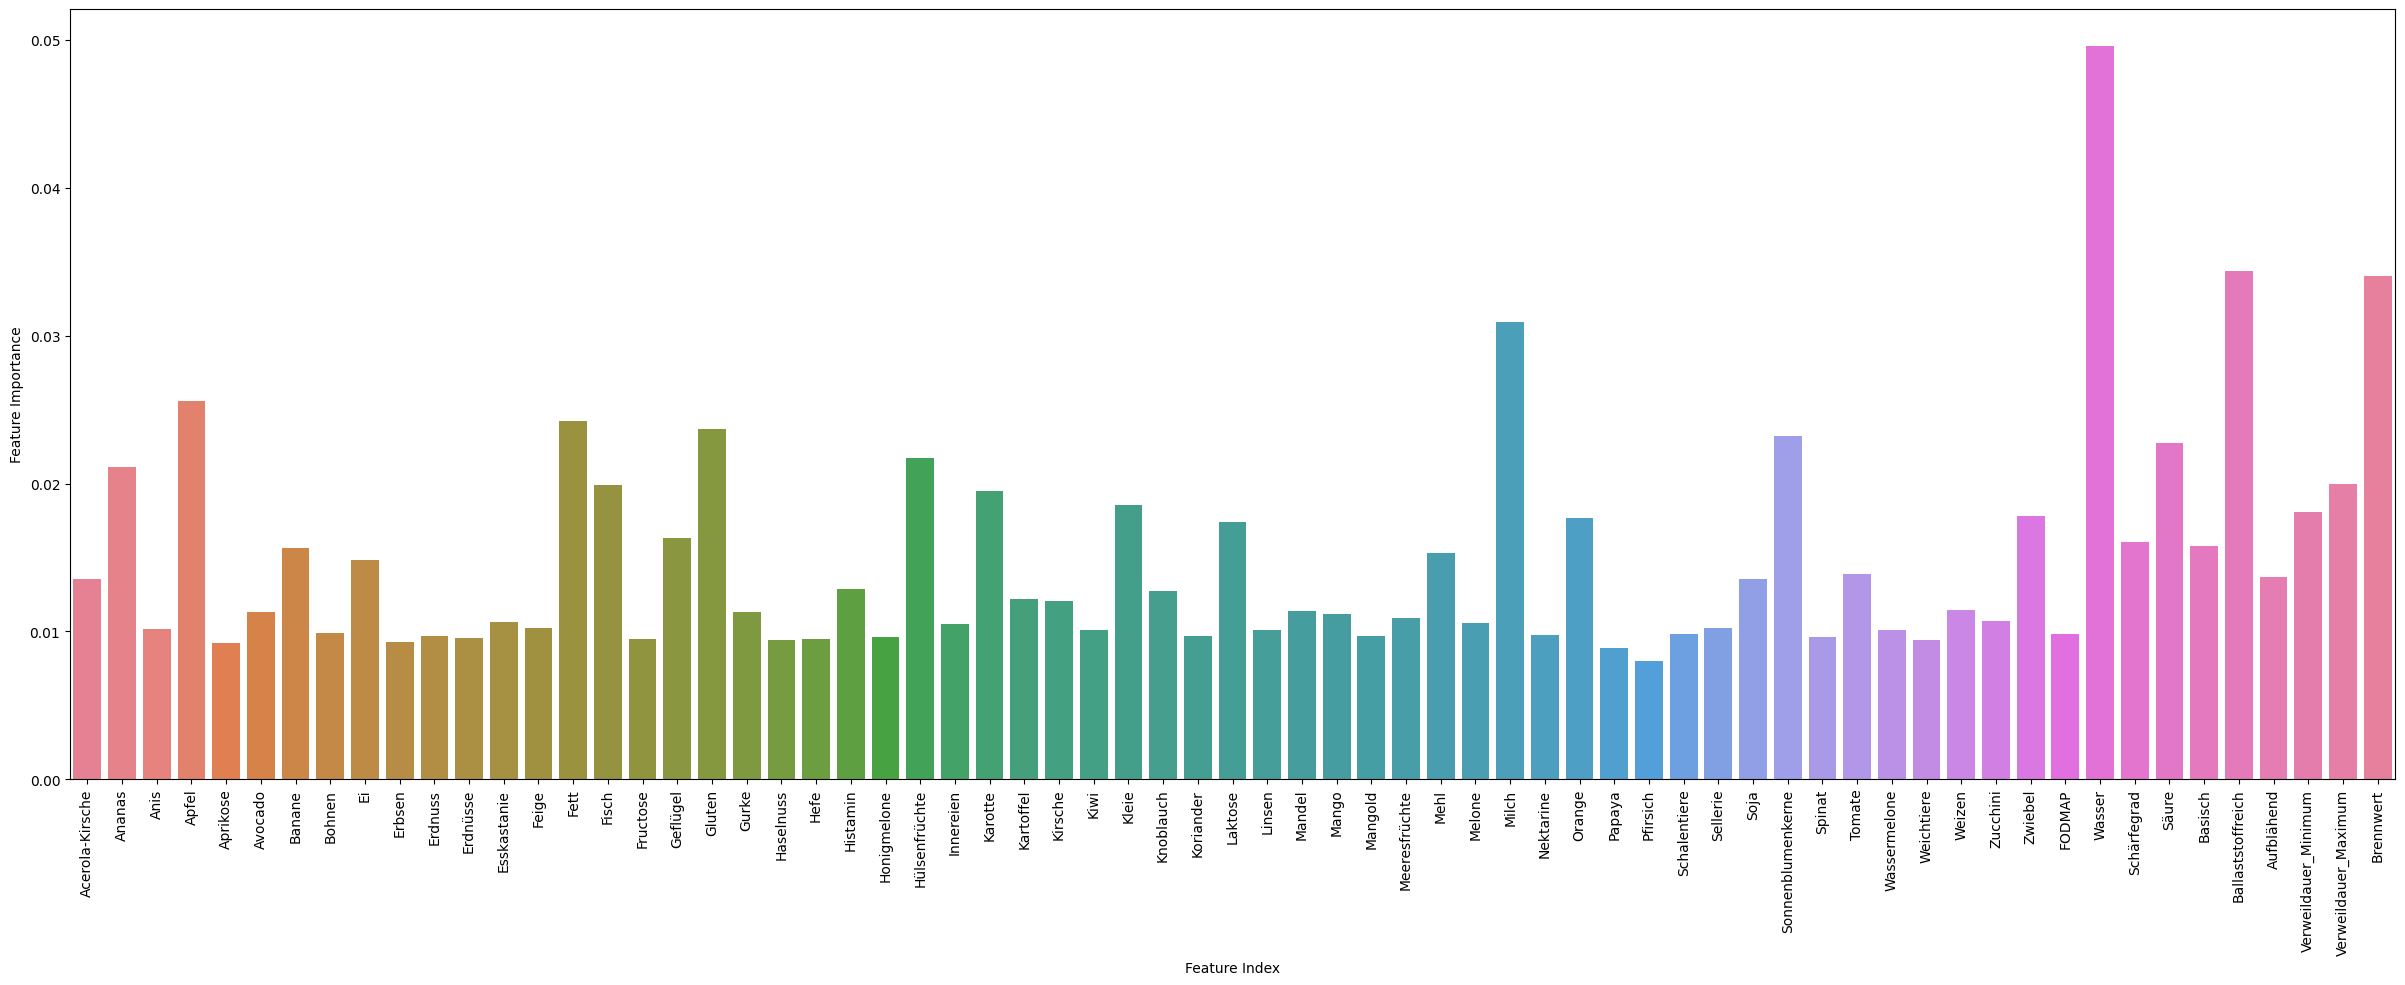

In [46]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Scale/normalize features (optional)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X.drop(columns=['Messung']))

# Train a Random Forest classifier
rf = RandomForestRegressor(n_estimators=300, random_state=np.random.randint(1, 1000))
rf.fit(df_scaled, y.drop(columns=['Messung']))

# Access feature importance
importances = rf.feature_importances_

# Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(30, 10))
ax = sns.barplot(pd.DataFrame({e: [i] for e,i in zip(explaining_features, importances)}))
ax.xaxis.set_tick_params(rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

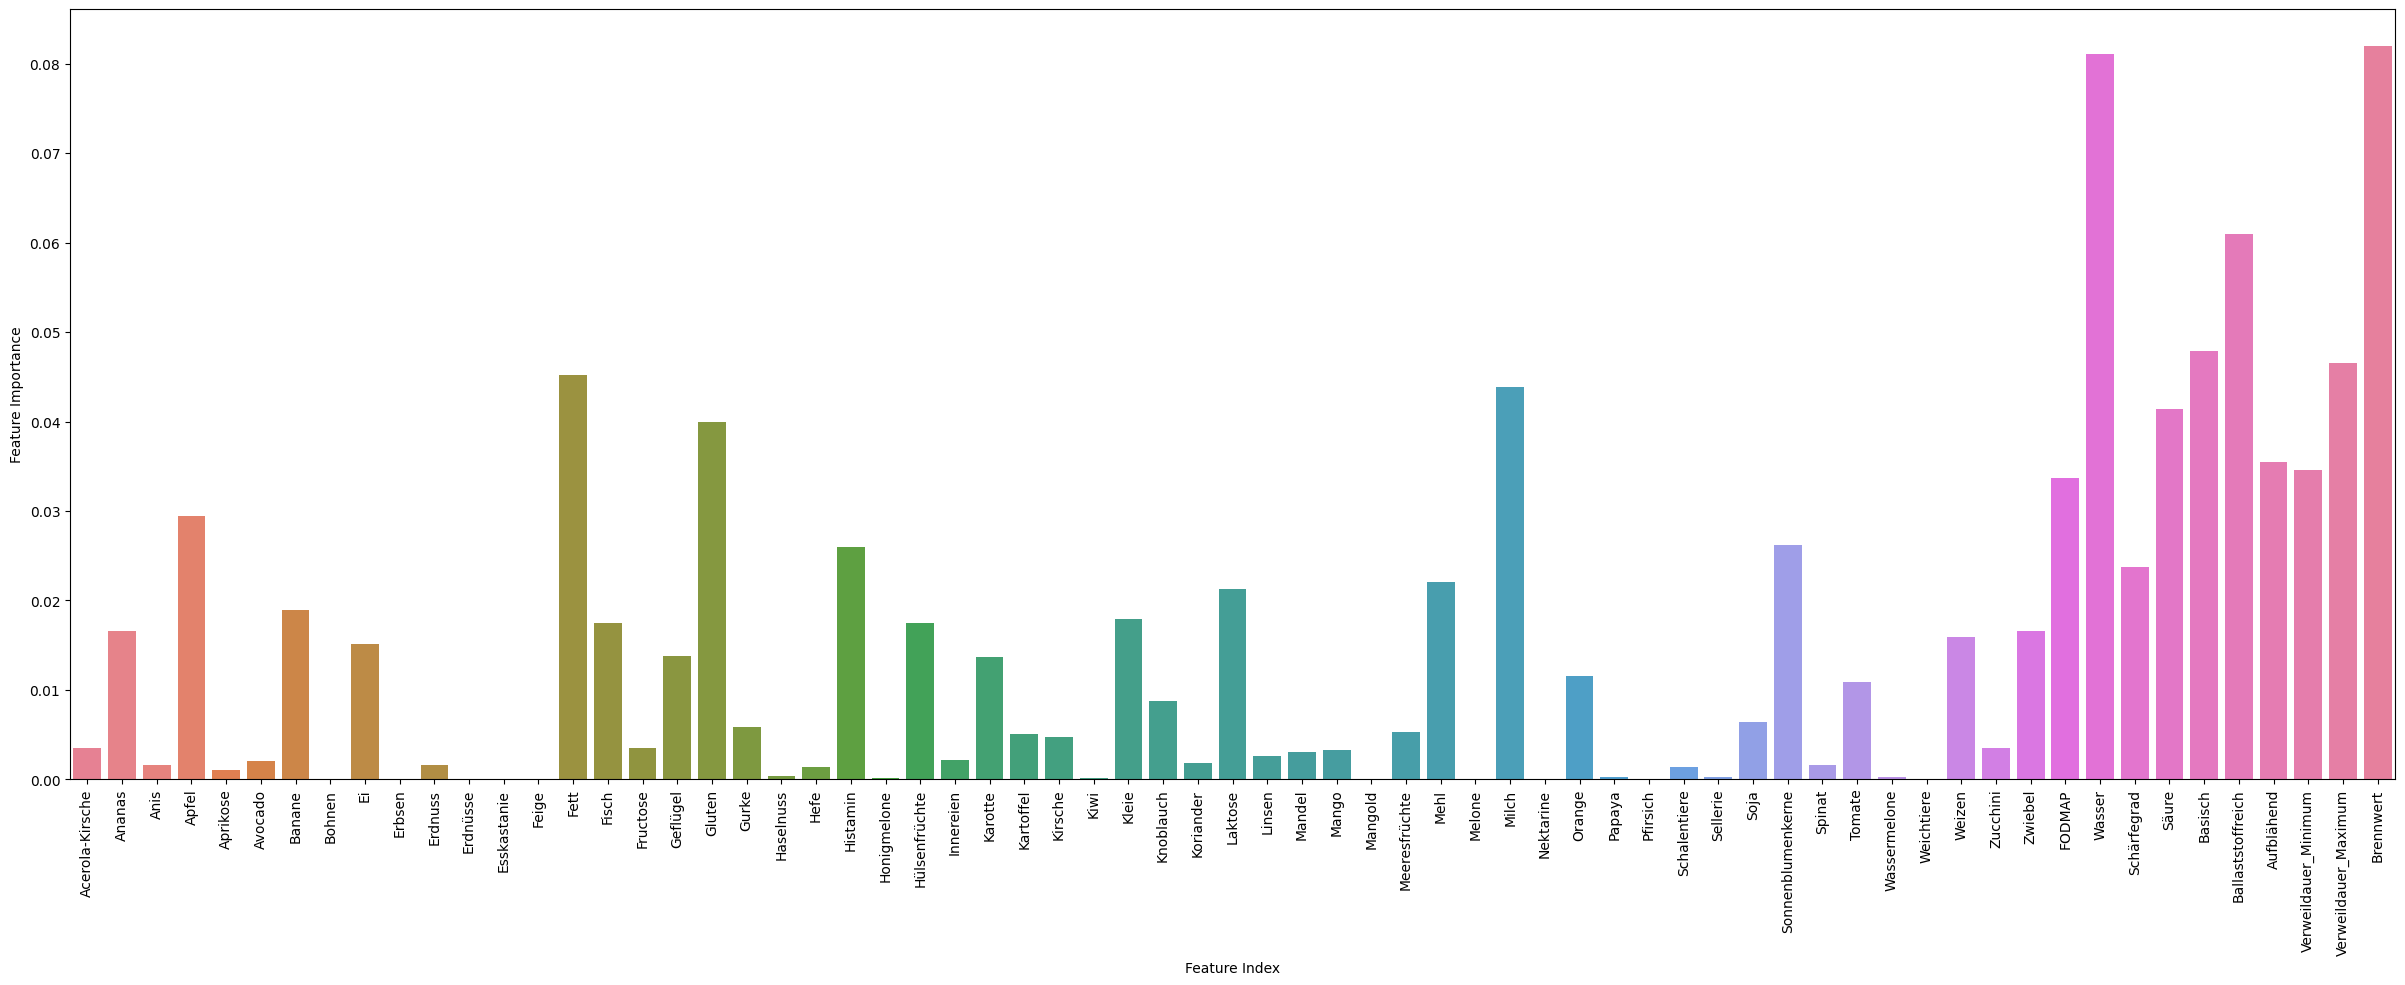

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Scale/normalize features (optional)
scaler = StandardScaler()

# Train a Random Forest classifier
rf = RandomForestRegressor(n_estimators=300, random_state=np.random.randint(1, 1000))
rf.fit(XX.drop(columns=['Messung']), y.drop(columns=['Messung']))

# Access feature importance
importances = rf.feature_importances_

# Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(30, 10))
ax = sns.barplot(pd.DataFrame({e: [i] for e,i in zip(explaining_features, importances)}))
ax.xaxis.set_tick_params(rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

In [66]:
model = FeatureSelectionModel(
    X.set_index(index_name),
    y,
    observable_patterns_result['df_cluster_median'],
    num_virtual_features=1,
    power = 4.,
    index_name = index_name,
    num_samples = 10,
    dtype = torch.float64,
    device = 'cpu',
    penalty=0.00,
    noise = 1e-5
)
model.decisive = False

In [67]:
_clus_pos = model.constrained('cluster_positions').clamp(min = 1e-10, max=1e10).clone().detach().numpy().round(3)

# Number of epochs
EPOCHS = 10

# After this many steps, the learning rate is halved
HALFLIFE = int(EPOCHS / 3)

'''optimizer = torch.optim.RMSprop(
    params = [
        {'params': model.parameters['feature_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['observation_weights'], 'lr': 0.1, 'momentum': 0.50},
        {'params': model.parameters['cluster_positions'], 'lr': 0.1, 'momentum': 0.50},
    ],

)'''
optimizer = torch.optim.RMSprop(lr=0.10, momentum=0.50, params=model.parameters.parameters())

lr_halflife = lambda epochs: 0.5**(1/epochs)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_halflife(HALFLIFE)**epoch)
trainer = Trainer(model = model, optimizer = optimizer, scheduler = scheduler, dataloader = range(100))
print(f'Loss before training: {model.loss().clone().detach()}')
print(f'Correlation before training: {model.get_coef()}')
print('')
trainer.train(epochs = EPOCHS, timeout=60000)
print('')
print(f'Correlation after training: {model.get_coef()}')
if False:
    print('')
    model.decisive = True
    trainer.train(epochs = 10, timeout=60000)
    print('')
    print(f'Correlation after training: {model.get_coef()}')

Loss before training: -0.010000925430635124
Correlation before training: 0.010000933457773547

1/10 --- Mean Loss : -0.07720685124017083
2/10 --- Mean Loss : -0.0837678741519033
3/10 --- Mean Loss : -0.08483927553705044
4/10 --- Mean Loss : -0.08586573482833716
5/10 --- Mean Loss : -0.08643150787508658
6/10 --- Mean Loss : -0.08644366891957828
7/10 --- Mean Loss : -0.08644822506651788
8/10 --- Mean Loss : -0.08645060210574744
9/10 --- Mean Loss : -0.08645200965569545
10/10 --- Mean Loss : -0.08645278644940319

Correlation after training: 0.08645202170436907


In [68]:
_clus_pos2 = model.constrained('cluster_positions').clamp(min = 1e-10, max=1e10).clone().detach().numpy().round(3)
_clus_pos2

array([[0.653, 0.011, 0.427, 0.12 , 0.01 , 0.01 ],
       [0.653, 0.448, 0.926, 0.122, 0.41 , 0.01 ],
       [0.01 , 0.51 , 0.343, 0.123, 0.709, 0.01 ],
       [0.009, 0.322, 0.677, 0.898, 0.21 , 0.198],
       [0.224, 0.261, 0.344, 0.287, 0.409, 0.948],
       [0.01 , 0.634, 0.593, 0.733, 0.709, 0.635],
       [1.   , 0.758, 0.843, 0.676, 1.   , 0.633],
       [0.009, 0.071, 0.261, 0.066, 0.311, 0.01 ],
       [0.01 , 0.01 , 0.344, 0.009, 1.   , 0.51 ],
       [0.009, 0.886, 0.343, 0.4  , 0.41 , 0.009],
       [0.582, 0.259, 0.677, 0.231, 1.   , 0.01 ],
       [0.583, 0.26 , 0.343, 0.231, 0.408, 0.009],
       [0.582, 0.761, 0.677, 0.453, 0.208, 0.261]])

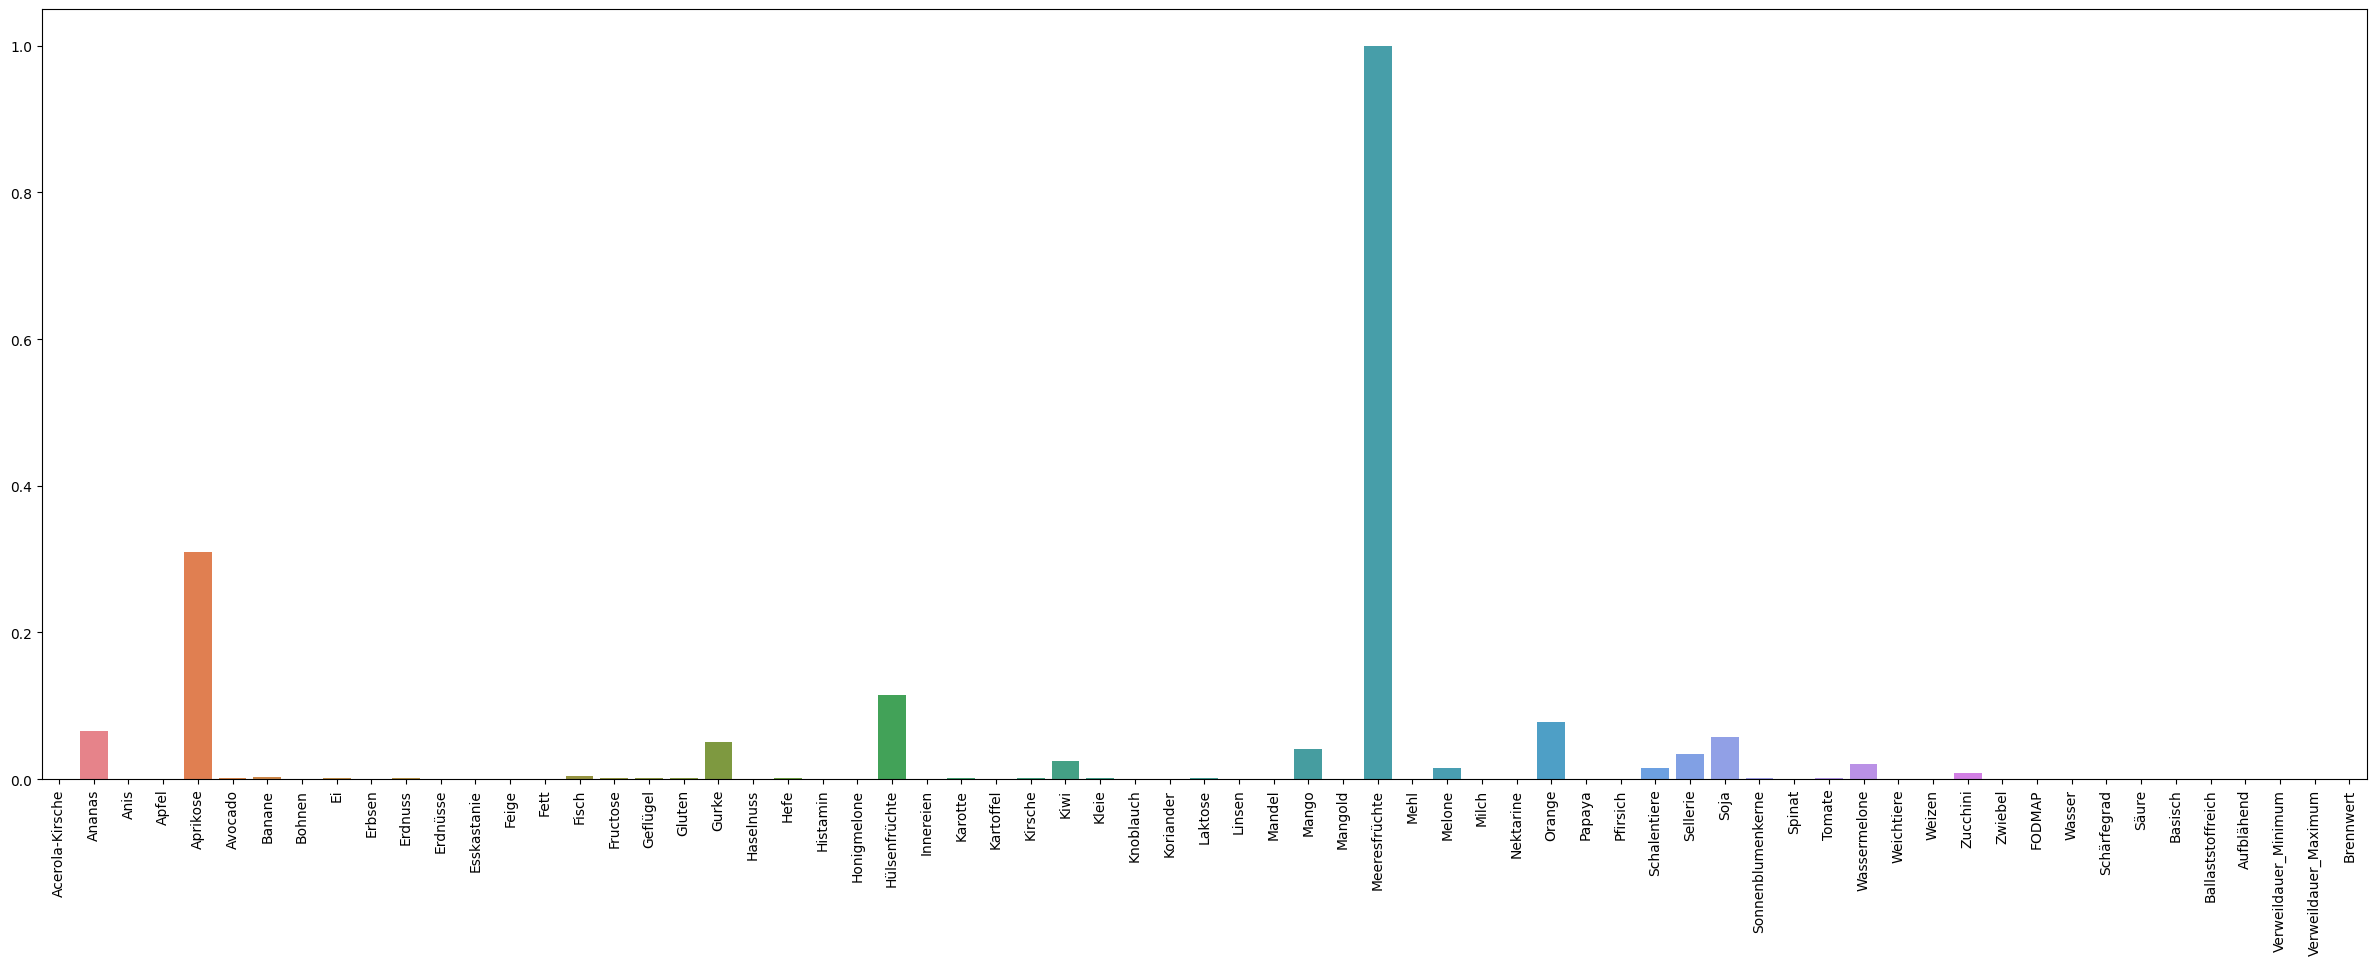

In [69]:
fig = plt.figure(figsize=(30, 10))
ax = sns.barplot(pd.DataFrame({f:[u] for f,u in zip(explaining_features, model.constrained('feature_weights').clone().detach().numpy().round(3))}))
ax.axes.xaxis.set_tick_params(rotation=90)

<Axes: >

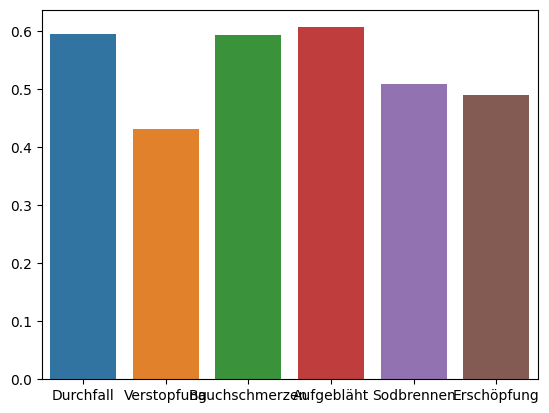

In [70]:
sns.barplot(pd.DataFrame({
    f:[i] for f,i in zip(observed_features, model.constrained('observation_weights').clone().detach().numpy().round(3))
}))

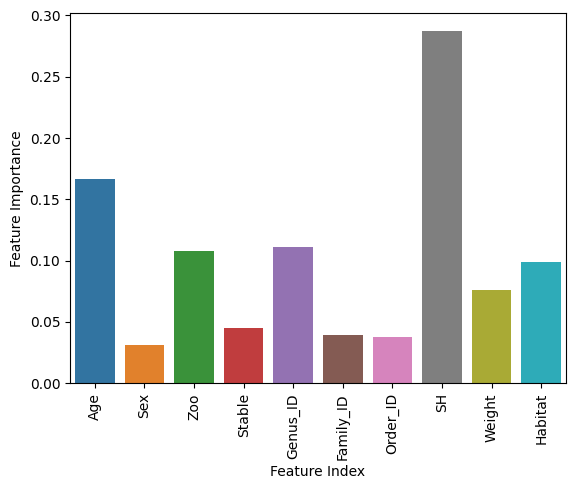

In [45]:
df_obs = df_observable.set_index('Individual')
df_exp = df_explainable.loc[df_obs.index]

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Scale/normalize features (optional)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_exp)

# Train a Random Forest classifier
rf = RandomForestRegressor(n_estimators=100, random_state=np.random.randint(1, 1000))
rf.fit(df_scaled, df_obs)

# Access feature importance
importances = rf.feature_importances_

# Visualize feature importance
import matplotlib.pyplot as plt
ax = sns.barplot(pd.DataFrame({e: [i] for e,i in zip(explaining_features, importances)}))
ax.xaxis.set_tick_params(rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

In [443]:
...

Ellipsis